In [1]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
#suspress warnings
import warnings
warnings.filterwarnings('ignore')
from sklearn.decomposition import PCA

Mounted at /content/drive


In [2]:
# Read the CSV file into a DataFrame named df1
df1 = pd.read_csv("/content/archive (5).zip")
df1.head()

,Index,Price,Currency,Condition,Vehicle_brand,Vehicle_model,Vehicle_version,Vehicle_generation,Production_year,Mileage_km,...,Transmission,Type,Doors_number,Colour,Origin_country,First_owner,First_registration_date,Offer_publication_date,Offer_location,Features
0,0,86200,PLN,New,Abarth,595,NaN,NaN,2021,1.0,...,Manual,small_cars,3.0,gray,NaN,NaN,NaN,04/05/2021,"ul. Jubilerska 6 - 04-190 Warszawa, Mazowiecki...",[]
1,1,43500,PLN,Used,Abarth,Other,NaN,NaN,1974,59000.0,...,Manual,coupe,2.0,silver,NaN,NaN,NaN,03/05/2021,"kanonierska12 - 04-425 Warszawa, Rembertów (Po...",[]
2,2,44900,PLN,Used,Abarth,500,NaN,NaN,2018,52000.0,...,Automatic,small_cars,3.0,silver,NaN,NaN,NaN,03/05/2021,"Warszawa, Mazowieckie, Białołęka","['ABS', 'Electric front windows', 'Drivers air..."
3,3,39900,PLN,Used,Abarth,500,NaN,NaN,2012,29000.0,...,Manual,small_cars,3.0,gray,NaN,NaN,NaN,30/04/2021,"Jaworzno, Śląskie","['ABS', 'Electric front windows', 'Drivers air..."
4,4,97900,PLN,New,Abarth,595,NaN,NaN,2021,600.0,...,Manual,small_cars,3.0,blue,NaN,NaN,NaN,30/04/2021,"ul. Gorzysława 9 - 61-057 Poznań, Nowe Miasto ...","['ABS', 'Electrically adjustable mirrors', 'Pa..."


In [3]:
df1.shape
df1.columns

Index(['Index', 'Price', 'Currency', 'Condition', 'Vehicle_brand',
       'Vehicle_model', 'Vehicle_version', 'Vehicle_generation',
       'Production_year', 'Mileage_km', 'Power_HP', 'Displacement_cm3',
       'Fuel_type', 'CO2_emissions', 'Drive', 'Transmission', 'Type',
       'Doors_number', 'Colour', 'Origin_country', 'First_owner',
       'First_registration_date', 'Offer_publication_date', 'Offer_location',
       'Features'],
      dtype='object')

In [4]:
df1.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 208304 entries, 0 to 208303
Data columns (total 25 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Index                    208304 non-null  int64  
 1   Price                    208304 non-null  int64  
 2   Currency                 208304 non-null  object 
 3   Condition                208304 non-null  object 
 4   Vehicle_brand            208304 non-null  object 
 5   Vehicle_model            208304 non-null  object 
 6   Vehicle_version          138082 non-null  object 
 7   Vehicle_generation       147860 non-null  object 
 8   Production_year          208304 non-null  int64  
 9   Mileage_km               207321 non-null  float64
 10  Power_HP                 207661 non-null  float64
 11  Displacement_cm3         206338 non-null  float64
 12  Fuel_type                208304 non-null  object 
 13  CO2_emissions            94047 non-null   float64
 14  Driv

In [5]:
#check for duplicates
duplicates = df1[df1.duplicated()]
num_duplicates = duplicates.shape[0]
print(f'Number of duplicates: {num_duplicates}')

Number of duplicates: 0


In [6]:
print(df1['Currency'].unique())

['PLN' 'EUR']


In [7]:
unique_currency_counts = df1['Currency'].value_counts()
print(unique_currency_counts)

Currency
PLN    208034
EUR       270
Name: count, dtype: int64


In [8]:
# Define currency conversion rates
currency_rate_pln_to_eur = 0.23

# Convert Zloti to Euros
df1.loc[df1['Currency'] == 'PLN', 'Price'] = df1.loc[df1['Currency'] == 'PLN', 'Price'] * currency_rate_pln_to_eur


In [9]:
# Format 'Price' column with commas as thousand separators
df1['Price'] = df1['Price'].apply(lambda x: "{:,.0f}".format(x))

# Print the first few rows of the 'Price' column
print(df1['Price'].head())

0    19,826
1    10,005
2    10,327
3     9,177
4    22,517
Name: Price, dtype: object


In [10]:
# Remove commas from the 'Price' column
df1['Price'] = df1['Price'].str.replace(',', '')

# Convert 'Price' column to numeric
df1['Price'] = pd.to_numeric(df1['Price'], errors='coerce')

# Print the data type of the 'Price' column to verify the change
print(df1['Price'].dtype)

int64


In [11]:

print(df1['Price'].head())

0    19826
1    10005
2    10327
3     9177
4    22517
Name: Price, dtype: int64


In [12]:
price_statistics = df1['Price'].describe()
print(price_statistics)

count    2.083040e+05
mean     1.455844e+04
std      2.039693e+04
min      1.350000e+02
25%      4.094000e+03
50%      8.234000e+03
75%      1.748000e+04
max      1.609770e+06
Name: Price, dtype: float64


Keep only used cars for my model

In [13]:
print(df1['Condition'].unique())
unique_Condition_counts = df1['Condition'].value_counts()
print(unique_Condition_counts)

['New' 'Used']
Condition
Used    182850
New      25454
Name: count, dtype: int64


In [14]:
# Filter rows where Condition is 'Used' and overwrite df1
df1 = df1[df1['Condition'] == 'Used']

In [15]:
print(df1['Condition'].unique())
unique_Condition_counts = df1['Condition'].value_counts()
print(unique_Condition_counts)

['Used']
Condition
Used    182850
Name: count, dtype: int64


In [16]:
print(df1['Fuel_type'].unique())
unique_Fuel_type_counts = df1['Fuel_type'].value_counts()
print(unique_Fuel_type_counts)

['Gasoline' 'Gasoline + LPG' 'Diesel' 'Electric' 'Hybrid' 'Gasoline + CNG'
 'Hydrogen' 'Ethanol']
Fuel_type
Diesel            86391
Gasoline          83442
Gasoline + LPG     8611
Hybrid             3502
Electric            830
Gasoline + CNG       70
Hydrogen              2
Ethanol               2
Name: count, dtype: int64


In [17]:
# Filter rows where Fuel_type is 'Diesel' or 'Gasoline' and overwrite df1
df1 = df1[df1['Fuel_type'].isin(['Diesel', 'Gasoline'])]


In [18]:
print(df1['Fuel_type'].unique())
unique_Fuel_type_counts = df1['Fuel_type'].value_counts()
print(unique_Fuel_type_counts)

['Gasoline' 'Diesel']
Fuel_type
Diesel      86391
Gasoline    83442
Name: count, dtype: int64


Select specific columns for my model

In [19]:
# Select only the specified variables
df1 = df1[['Price', 'Production_year', 'Mileage_km', 'Power_HP', 'Displacement_cm3',
           'Fuel_type', 'Drive', 'Transmission', 'Type','Doors_number', 'Colour', 'Features']]

In [20]:
df1.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 169833 entries, 1 to 208303
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Price             169833 non-null  int64  
 1   Production_year   169833 non-null  int64  
 2   Mileage_km        169833 non-null  float64
 3   Power_HP          169294 non-null  float64
 4   Displacement_cm3  169472 non-null  float64
 5   Fuel_type         169833 non-null  object 
 6   Drive             156404 non-null  object 
 7   Transmission      169401 non-null  object 
 8   Type              169833 non-null  object 
 9   Doors_number      168702 non-null  float64
 10  Colour            169833 non-null  object 
 11  Features          169833 non-null  object 
dtypes: float64(4), int64(2), object(6)
memory usage: 16.8+ MB


Check and handle nas

In [21]:
#check for nas
missing_values = df1.isna()
missing_count = df1.isna().sum()
print(missing_count)


Price                   0
Production_year         0
Mileage_km              0
Power_HP              539
Displacement_cm3      361
Fuel_type               0
Drive               13429
Transmission          432
Type                    0
Doors_number         1131
Colour                  0
Features                0
dtype: int64


Since the number of the nas is relatively small i use median for numerical variables and mode for categorical variables to handle nas instead of more complex techniques.

In [22]:
# Define numerical columns with missing values
numerical_columns_with_missing_values = ['Power_HP', 'Displacement_cm3', 'Doors_number']

# Define object columns with missing values
object_columns_with_missing_values = ['Drive', 'Transmission']

# Impute missing values with median for numerical columns
for column in numerical_columns_with_missing_values:
    df1[column].fillna(df1[column].median(), inplace=True)

# Impute missing values with mode for object columns
for column in object_columns_with_missing_values:
    df1[column].fillna(df1[column].mode()[0], inplace=True)

In [23]:
#check for nas
missing_values = df1.isna()
missing_count = df1.isna().sum()
print(missing_count)

Price               0
Production_year     0
Mileage_km          0
Power_HP            0
Displacement_cm3    0
Fuel_type           0
Drive               0
Transmission        0
Type                0
Doors_number        0
Colour              0
Features            0
dtype: int64


In [24]:
from sklearn.preprocessing import MultiLabelBinarizer

In [25]:
features_column = df1['Features']

# Remove square brackets, white spaces, and single quotes from the values
features_column = features_column.str.replace(r'[\[\]\s\']', '')

# Split the values by comma
features_column = features_column.str.split(',')

# Initialize MultiLabelBinarizer
mlb = MultiLabelBinarizer()

# Create binary indicator variables for each feature
features_encoded = pd.DataFrame(mlb.fit_transform(features_column), columns=mlb.classes_,index=df1.index)

# Select variables with both 1 and 0
selected_features = features_encoded.loc[:, (features_encoded.sum(axis=0) > 0)]

# Concatenate selected features with original DataFrame
df1 = pd.concat([df1, selected_features], axis=1)

# Drop the original 'Features' column
df1.drop('Features', axis=1, inplace=True)

In [26]:
print(df1.head())

   Price  Production_year  Mileage_km  Power_HP  Displacement_cm3 Fuel_type  \
1  10005             1974     59000.0      75.0            1100.0  Gasoline   
2  10327             2018     52000.0     180.0            1368.0  Gasoline   
3   9177             2012     29000.0     160.0            1368.0  Gasoline   
5  14478             2016     46060.0     180.0            1368.0  Gasoline   
6  16077             2021      2900.0     145.0            1368.0  Gasoline   

          Drive Transmission        Type  Doors_number  ... ['Sunroof'  \
1  Front wheels       Manual       coupe           2.0  ...          0   
2  Front wheels    Automatic  small_cars           3.0  ...          0   
3  Front wheels       Manual  small_cars           3.0  ...          0   
5  Front wheels       Manual  small_cars           3.0  ...          0   
6  Front wheels       Manual  small_cars           2.0  ...          0   

   ['Sunroof']  ['Tinted windows'  ['Twilight sensor'  ['USB socket'  \
1       

In [27]:
df1.columns

Index(['Price', 'Production_year', 'Mileage_km', 'Power_HP',
       'Displacement_cm3', 'Fuel_type', 'Drive', 'Transmission', 'Type',
       'Doors_number',
       ...
       '['Sunroof'', '['Sunroof']', '['Tinted windows'', '['Twilight sensor'',
       '['USB socket'', '['Velor upholstery'', '['Velor upholstery']',
       '['Xenon lights'', '['Xenon lights']', '[]'],
      dtype='object', length=243)

In [28]:
# Sum the values for each column
column_sums = df1.iloc[:, 12:].sum()

# Find columns with only 0 values
columns_with_only_zeros = column_sums[column_sums == 0].index

# Discard columns with only 0 values
df1_useful = df1.drop(columns_with_only_zeros, axis=1)

# Print the columns with only 0 values
print("Columns with only 0 values:", columns_with_only_zeros)

# Print the remaining useful columns
print("Remaining useful columns:")
print(df1_useful.head())


Columns with only 0 values: Index([], dtype='object')
Remaining useful columns:
   Price  Production_year  Mileage_km  Power_HP  Displacement_cm3 Fuel_type  \
1  10005             1974     59000.0      75.0            1100.0  Gasoline   
2  10327             2018     52000.0     180.0            1368.0  Gasoline   
3   9177             2012     29000.0     160.0            1368.0  Gasoline   
5  14478             2016     46060.0     180.0            1368.0  Gasoline   
6  16077             2021      2900.0     145.0            1368.0  Gasoline   

          Drive Transmission        Type  Doors_number  ... ['Sunroof'  \
1  Front wheels       Manual       coupe           2.0  ...          0   
2  Front wheels    Automatic  small_cars           3.0  ...          0   
3  Front wheels       Manual  small_cars           3.0  ...          0   
5  Front wheels       Manual  small_cars           3.0  ...          0   
6  Front wheels       Manual  small_cars           2.0  ...          0   



In [29]:
df1_useful.columns

Index(['Price', 'Production_year', 'Mileage_km', 'Power_HP',
       'Displacement_cm3', 'Fuel_type', 'Drive', 'Transmission', 'Type',
       'Doors_number',
       ...
       '['Sunroof'', '['Sunroof']', '['Tinted windows'', '['Twilight sensor'',
       '['USB socket'', '['Velor upholstery'', '['Velor upholstery']',
       '['Xenon lights'', '['Xenon lights']', '[]'],
      dtype='object', length=243)

In [30]:
# Check if there are columns with only 0 values
if len(columns_with_only_zeros) == 0:
    print("No columns with only 0 values found.")
else:
    print("Columns with only 0 values:", columns_with_only_zeros)

No columns with only 0 values found.


In [31]:
# Print the column names of the remaining useful columns
print("Column names of the remaining useful columns:")
print(df1_useful.columns.tolist())

Column names of the remaining useful columns:
['Price', 'Production_year', 'Mileage_km', 'Power_HP', 'Displacement_cm3', 'Fuel_type', 'Drive', 'Transmission', 'Type', 'Doors_number', 'Colour', " 'ABS'", " 'ABS']", " 'ASR (traction control)'", " 'ASR (traction control)']", " 'AUX socket'", " 'AUX socket']", " 'Active cruise control'", " 'Active cruise control']", " 'Adjustable suspension'", " 'Adjustable suspension']", " 'Aftermarket radio'", " 'Aftermarket radio']", " 'Air curtains'", " 'Air curtains']", " 'Airbag protecting the knees'", " 'Airbag protecting the knees']", " 'Alarm'", " 'Alarm']", " 'Alloy wheels'", " 'Alloy wheels']", " 'Automatic air conditioning'", " 'Automatic air conditioning']", " 'Auxiliary heating'", " 'Auxiliary heating']", " 'Blind spot sensor'", " 'Blind spot sensor']", " 'Bluetooth'", " 'Bluetooth']", " 'CD changer'", " 'CD changer']", " 'CD'", " 'CD']", " 'Central locking'", " 'Central locking']", " 'Cruise control'", " 'Cruise control']", " 'DVD player'", 

In [32]:
# Select the columns to preserve
columns_to_preserve = ['Price', 'Production_year', 'Mileage_km', 'Power_HP', 'Displacement_cm3',
                       'Fuel_type', 'Drive', 'Transmission', 'Type','Colour', 'Doors_number']

# Calculate the sum of binary variables across rows
df1_useful['Extras'] = df1_useful.drop(columns=columns_to_preserve).sum(axis=1)

# Drop the initial binary columns
df1_useful.drop(columns=df1_useful.columns.difference(columns_to_preserve + ['Extras']), inplace=True)


In [33]:
df1_useful.columns

Index(['Price', 'Production_year', 'Mileage_km', 'Power_HP',
       'Displacement_cm3', 'Fuel_type', 'Drive', 'Transmission', 'Type',
       'Doors_number', 'Colour', 'Extras'],
      dtype='object')

In [34]:
df1_useful.info()

<class 'pandas.core.frame.DataFrame'>
Index: 169833 entries, 1 to 208303
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Price             169833 non-null  int64  
 1   Production_year   169833 non-null  int64  
 2   Mileage_km        169833 non-null  float64
 3   Power_HP          169833 non-null  float64
 4   Displacement_cm3  169833 non-null  float64
 5   Fuel_type         169833 non-null  object 
 6   Drive             169833 non-null  object 
 7   Transmission      169833 non-null  object 
 8   Type              169833 non-null  object 
 9   Doors_number      169833 non-null  float64
 10  Colour            169833 non-null  object 
 11  Extras            169833 non-null  int64  
dtypes: float64(4), int64(3), object(5)
memory usage: 16.8+ MB


In [35]:
df1_useful.head()

,Price,Production_year,Mileage_km,Power_HP,Displacement_cm3,Fuel_type,Drive,Transmission,Type,Doors_number,Colour,Extras
1,10005,1974,59000.0,75.0,1100.0,Gasoline,Front wheels,Manual,coupe,2.0,silver,1
2,10327,2018,52000.0,180.0,1368.0,Gasoline,Front wheels,Automatic,small_cars,3.0,silver,21
3,9177,2012,29000.0,160.0,1368.0,Gasoline,Front wheels,Manual,small_cars,3.0,gray,23
5,14478,2016,46060.0,180.0,1368.0,Gasoline,Front wheels,Manual,small_cars,3.0,gray,30
6,16077,2021,2900.0,145.0,1368.0,Gasoline,Front wheels,Manual,small_cars,2.0,black,1


In [36]:
df1_useful['Extras'].describe()

count    169833.000000
mean         28.815142
std          14.478647
min           1.000000
25%          19.000000
50%          29.000000
75%          40.000000
max          70.000000
Name: Extras, dtype: float64

In [37]:
print(df1_useful['Extras'].head())

1     1
2    21
3    23
5    30
6     1
Name: Extras, dtype: int64


In [38]:
df1_useful.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 169833 entries, 1 to 208303
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Price             169833 non-null  int64  
 1   Production_year   169833 non-null  int64  
 2   Mileage_km        169833 non-null  float64
 3   Power_HP          169833 non-null  float64
 4   Displacement_cm3  169833 non-null  float64
 5   Fuel_type         169833 non-null  object 
 6   Drive             169833 non-null  object 
 7   Transmission      169833 non-null  object 
 8   Type              169833 non-null  object 
 9   Doors_number      169833 non-null  float64
 10  Colour            169833 non-null  object 
 11  Extras            169833 non-null  int64  
dtypes: float64(4), int64(3), object(5)
memory usage: 16.8+ MB


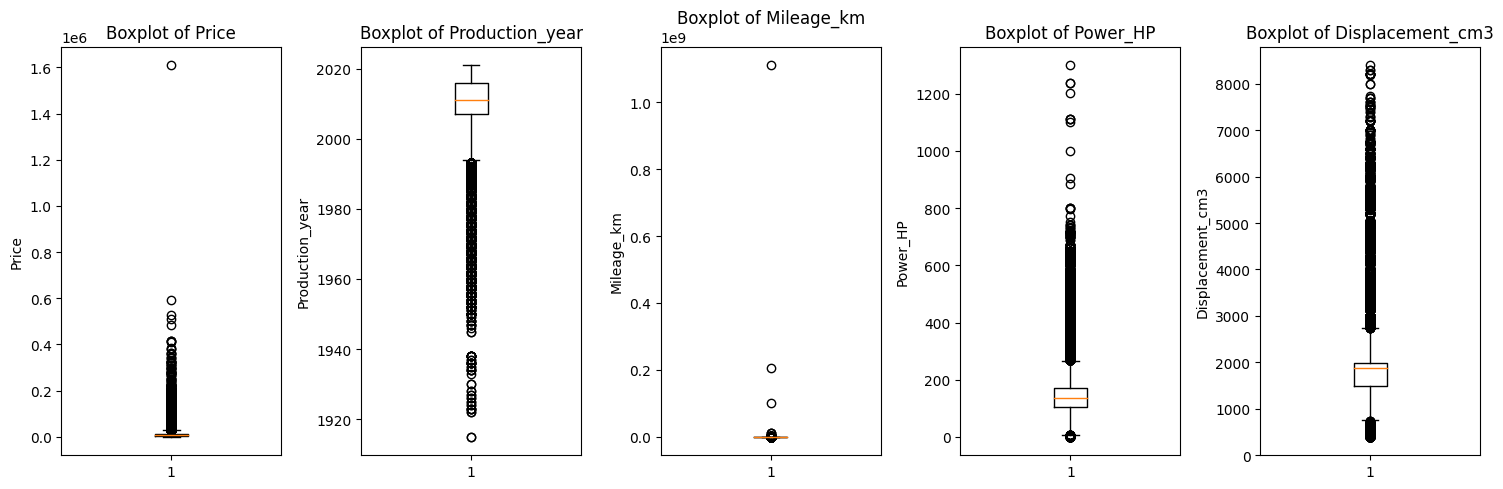

In [39]:
import matplotlib.pyplot as plt

# Selecting only the numerical columns
numerical_columns = ['Price', 'Production_year', 'Mileage_km', 'Power_HP', 'Displacement_cm3']

# Creating boxplots for each numerical column to detect outliers
plt.figure(figsize=(15, 5))
for i, column in enumerate(numerical_columns, 1):
    plt.subplot(1, len(numerical_columns), i)
    plt.boxplot(df1_useful[column])
    plt.title(f'Boxplot of {column}')
    plt.ylabel(column)

plt.tight_layout()
plt.show()

In [40]:
# Define a function to detect and handle outliers using z-scores
def handle_outliers_zscore(df, column):
    # Calculate z-scores for the column
    z_scores = (df[column] - df[column].mean()) / df[column].std()
    threshold = 3

    # Detect outliers
    outlier_detection = df[abs(z_scores) > threshold]
    print("Outlier records:")
    print(outlier_detection)
    print("\nNumber of outliers:", outlier_detection.shape[0])

    # Handle outliers by replacing them with median value
    median_value = df[column].median()
    df.loc[abs(z_scores) > threshold, column] = median_value

# Apply the function for each numerical column
numerical_columns = ['Price', 'Production_year', 'Mileage_km', 'Power_HP', 'Displacement_cm3']

for column in numerical_columns:
    print(f"\nHandling outliers for column: {column}")
    handle_outliers_zscore(df1_useful, column)


Handling outliers for column: Price
Outlier records:
        Price  Production_year  Mileage_km  Power_HP  Displacement_cm3  \
358     88550             2019      1550.0     510.0            2891.0   
514     71254             2018     45726.0     510.0            2891.0   
930     69299             2019     51235.0     510.0            2891.0   
1099    73577             2019     25000.0     510.0            2891.0   
1181    73554             2018     19532.0     510.0            2891.0   
...       ...              ...         ...       ...               ...   
207629  61424             2020     11000.0     235.0            1969.0   
207646  61870             2019     25950.0     235.0            1969.0   
207885  59777             2020     15000.0     235.0            1969.0   
207936  66930             2020       200.0     300.0            1969.0   
207955  60467             2019     25400.0     250.0            1969.0   

       Fuel_type                         Drive Transmissi

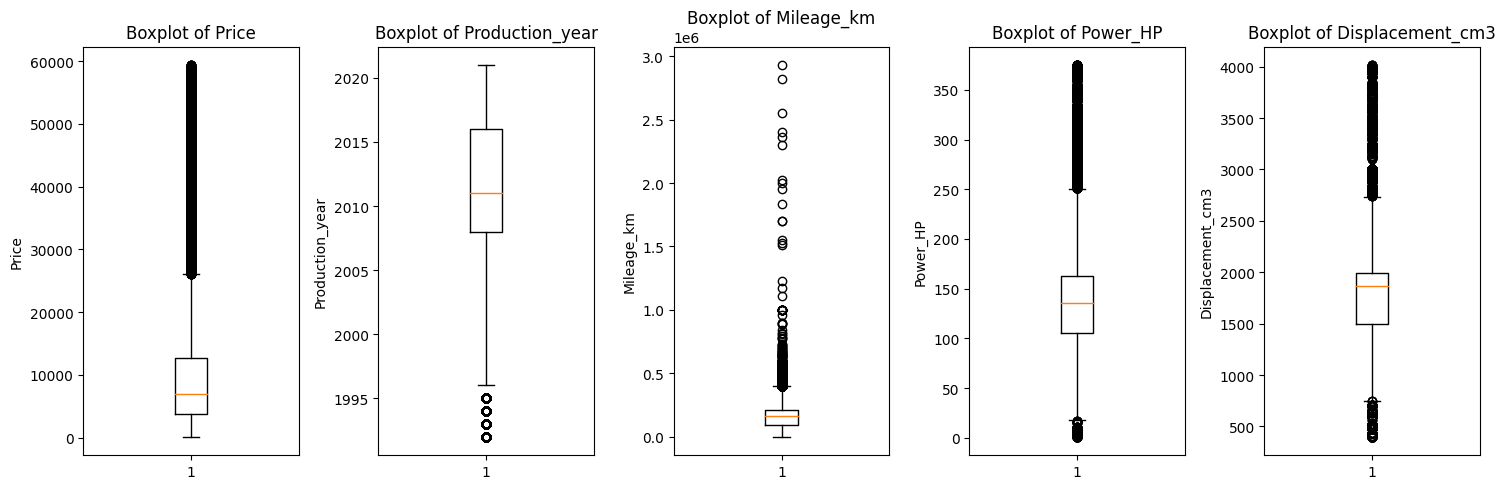

In [41]:
# Define numerical columns
numerical_columns = ['Price', 'Production_year', 'Mileage_km', 'Power_HP', 'Displacement_cm3']

# Creating boxplots for each numerical column to verify outliers after handling
plt.figure(figsize=(15, 5))
for i, column in enumerate(numerical_columns, 1):
    plt.subplot(1, len(numerical_columns), i)
    plt.boxplot(df1_useful[column])
    plt.title(f'Boxplot of {column}')
    plt.ylabel(column)

plt.tight_layout()
plt.show()

In [42]:
df1_useful.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 169833 entries, 1 to 208303
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Price             169833 non-null  int64  
 1   Production_year   169833 non-null  int64  
 2   Mileage_km        169833 non-null  float64
 3   Power_HP          169833 non-null  float64
 4   Displacement_cm3  169833 non-null  float64
 5   Fuel_type         169833 non-null  object 
 6   Drive             169833 non-null  object 
 7   Transmission      169833 non-null  object 
 8   Type              169833 non-null  object 
 9   Doors_number      169833 non-null  float64
 10  Colour            169833 non-null  object 
 11  Extras            169833 non-null  int64  
dtypes: float64(4), int64(3), object(5)
memory usage: 16.8+ MB


In [43]:
unique_values_fuel_type = df1_useful['Fuel_type'].value_counts()
print(unique_values_fuel_type)

Fuel_type
Diesel      86391
Gasoline    83442
Name: count, dtype: int64


In [44]:
unique_values_Drive = df1_useful['Drive'].value_counts()
print(unique_values_Drive)

Drive
Front wheels                    126595
Rear wheels                      16197
4x4 (permanent)                  13641
4x4 (attached automatically)     11160
4x4 (attached manually)           2240
Name: count, dtype: int64


In [45]:
df1_useful['Drive'].replace({'4x4 (permanent) ': '4x4', '4x4 (attached automatically)': '4x4', '4x4 (attached manually) ': '4x4'}, inplace=True)

# Get value counts after transformation
unique_values_Drive = df1_useful['Drive'].value_counts()

# Display the unique values and their counts
print(unique_values_Drive)

Drive
Front wheels               126595
Rear wheels                 16197
4x4 (permanent)             13641
4x4                         11160
4x4 (attached manually)      2240
Name: count, dtype: int64


In [46]:
# Replace specific unique values with '4x4'
df1_useful['Drive'] = df1_useful['Drive'].str.strip()  # Remove trailing whitespaces
df1_useful['Drive'].replace({'4x4 (permanent)': '4x4', '4x4 (attached automatically)': '4x4', '4x4 (attached manually)': '4x4'}, inplace=True)

# Get value counts after transformation
unique_values_Drive = df1_useful['Drive'].value_counts()

# Display the unique values and their counts
print(unique_values_Drive)

Drive
Front wheels    126595
4x4              27041
Rear wheels      16197
Name: count, dtype: int64


In [47]:
unique_values_Transmission = df1_useful['Transmission'].value_counts()
print(unique_values_Transmission)

Transmission
Manual       116167
Automatic     53666
Name: count, dtype: int64


In [48]:
unique_values_Type = df1_useful['Type'].value_counts()
print(unique_values_Type)

Type
station_wagon    35719
SUV              27863
sedan            27457
compact          26397
city_cars        20203
minivan          19278
coupe             5596
small_cars        4995
convertible       2325
Name: count, dtype: int64


In [49]:
# Replace specific unique values
df1_useful['Type'].replace({'small_cars': 'city_cars', 'minivan': 'station_wagon', 'convertible': 'coupe'}, inplace=True)

# Get value counts after transformation
unique_values_Type = df1_useful['Type'].value_counts()

# Display the unique values and their counts
print(unique_values_Type)

Type
station_wagon    54997
SUV              27863
sedan            27457
compact          26397
city_cars        25198
coupe             7921
Name: count, dtype: int64


In [50]:
unique_values_Colour = df1_useful['Colour'].value_counts()
print(unique_values_Colour)

Colour
black       43502
silver      26788
gray        25003
white       22923
blue        16847
other       11923
red          6740
brown        4648
green        2891
burgundy     2872
golden       2299
beige        2015
yellow        704
violet        678
Name: count, dtype: int64


In [51]:
# Replace specific unique values
df1_useful['Colour'].replace({'violet': 'blue', 'golden': 'other', 'burgundy': 'red', 'beige': 'other', 'green' :'other', 'yellow' :'other', 'brown' :'other' }, inplace=True)

# Get value counts after transformation
unique_values_Colour = df1_useful['Colour'].value_counts()

# Display the unique values and their counts
print(unique_values_Colour)

Colour
black     43502
silver    26788
gray      25003
other     24480
white     22923
blue      17525
red        9612
Name: count, dtype: int64


In [52]:
print(df1_useful.columns)

Index(['Price', 'Production_year', 'Mileage_km', 'Power_HP',
       'Displacement_cm3', 'Fuel_type', 'Drive', 'Transmission', 'Type',
       'Doors_number', 'Colour', 'Extras'],
      dtype='object')


In [53]:
# Replace 'Manual' with 0 and 'Automatic' with 1
df1_useful['Transmission'] = df1_useful['Transmission'].replace({'Manual': 0, 'Automatic': 1})

In [54]:
print(df1_useful['Transmission'].unique())

[0 1]


In [55]:
df1_useful['Transmission'].info()

<class 'pandas.core.series.Series'>
Index: 169833 entries, 1 to 208303
Series name: Transmission
Non-Null Count   Dtype
--------------   -----
169833 non-null  int64
dtypes: int64(1)
memory usage: 2.6 MB


In [56]:
print(unique_values_fuel_type)

Fuel_type
Diesel      86391
Gasoline    83442
Name: count, dtype: int64


In [57]:
# Replace unique with numbers
df1_useful['Fuel_type'] = df1_useful['Fuel_type'].replace({'Diesel': 0, 'Gasoline': 1})

In [58]:
print(df1_useful['Fuel_type'].unique())

[1 0]


In [59]:
df1_useful['Fuel_type'].dtype

dtype('int64')

In [60]:
print(unique_values_Drive)

Drive
Front wheels    126595
4x4              27041
Rear wheels      16197
Name: count, dtype: int64


In [61]:
# Replace unique with numbers
df1_useful['Drive'] = df1_useful['Drive'].replace({'Front wheels': 0, '4x4': 1, 'Rear wheels':-1})

In [62]:
print(df1_useful['Drive'].unique())
df1_useful['Drive'].dtype

[ 0 -1  1]


dtype('int64')

In [63]:
print(df1_useful['Type'].unique())

['coupe' 'city_cars' 'compact' 'SUV' 'sedan' 'station_wagon']


In [64]:
# Replace unique with numbers
df1_useful['Type'] = df1_useful['Type'].replace({'coupe': 0, 'city_cars': 1, 'SUV':-1, 'sedan':2, 'compact':-2,'station_wagon':3})

In [65]:
print(df1_useful['Type'].unique())
df1_useful['Type'].dtype

[ 0  1 -2 -1  2  3]


dtype('int64')

In [66]:
print(df1_useful['Colour'].unique())

['silver' 'gray' 'black' 'white' 'red' 'other' 'blue']


In [67]:
# Replace unique with numbers
df1_useful['Colour'] = df1_useful['Colour'].replace({'silver': 0, 'gray': 1, 'black':-1, 'white':2, 'red':-2,'other':3, 'blue':-3})

In [68]:
print(df1_useful['Type'].unique())
df1_useful['Type'].dtype

[ 0  1 -2 -1  2  3]


dtype('int64')

In [69]:
df1_useful.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 169833 entries, 1 to 208303
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Price             169833 non-null  int64  
 1   Production_year   169833 non-null  int64  
 2   Mileage_km        169833 non-null  float64
 3   Power_HP          169833 non-null  float64
 4   Displacement_cm3  169833 non-null  float64
 5   Fuel_type         169833 non-null  int64  
 6   Drive             169833 non-null  int64  
 7   Transmission      169833 non-null  int64  
 8   Type              169833 non-null  int64  
 9   Doors_number      169833 non-null  float64
 10  Colour            169833 non-null  int64  
 11  Extras            169833 non-null  int64  
dtypes: float64(4), int64(8)
memory usage: 16.8 MB


I observed positive skewness in the variables Price, Power_HP, Mileage_km, and Displacement_cm3 from the boxplot. To normalize these variables and potentially improve the model's performance, I applied a log10 transformation. This transformation can help in reducing the skewness by compressing the range of values

In [70]:
import numpy as np

# Apply log10 transformation to the specified columns and overwrite the original columns
df1_useful['Price'] = np.log10(df1_useful['Price'])
df1_useful['Power_HP'] = np.log10(df1_useful['Power_HP'] + 1)  # Adding 1 to avoid log(0)
df1_useful['Mileage_km'] = np.log10(df1_useful['Mileage_km'] + 1)
df1_useful['Displacement_cm3'] = np.log10(df1_useful['Displacement_cm3'] + 1)


In [71]:
df1_useful.head(3)

,Price,Production_year,Mileage_km,Power_HP,Displacement_cm3,Fuel_type,Drive,Transmission,Type,Doors_number,Colour,Extras
1,4.000217,2011,4.770859,1.880814,3.041787,1,0,0,0,2.0,0,1
2,4.013974,2018,4.716012,2.257679,3.136403,1,0,1,1,3.0,0,21
3,3.962701,2012,4.462413,2.206826,3.136403,1,0,0,1,3.0,1,23


PCA

Principal Component Names:
['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10', 'PC11', 'PC12']
Rotation Matrix:
[[ 1.43005816e-02  1.57158520e-01 -3.48430734e-03  5.00518349e-03
   2.15831141e-03 -6.08034289e-03  5.61062757e-03  1.03205891e-02
   5.08920172e-03  9.78249420e-03  5.00555414e-03  9.87285787e-01]
 [-4.79642043e-02 -9.82873666e-01  5.77246051e-02 -3.32525273e-04
   5.11687495e-03 -3.76164658e-03 -1.20548397e-02 -1.27061575e-02
   4.30496762e-02 -1.66434683e-02 -3.16692078e-02  1.57626885e-01]
 [ 8.97125205e-03 -3.66670277e-02 -2.98684760e-02 -1.47501066e-03
  -4.48954980e-03  5.26438052e-02  4.48572815e-02 -3.93962325e-03
  -9.75339416e-01 -3.27793285e-02 -2.00882180e-01  1.21000492e-02]
 [ 2.84719301e-03 -4.00280132e-02  1.81646748e-03 -8.05060295e-04
  -1.82649062e-04 -4.82191084e-04  1.18897578e-02 -4.07474397e-03
  -1.99586129e-01 -3.53132400e-06  9.78972516e-01  2.37890709e-03]
 [-5.60471027e-02 -1.02039978e-02  9.56564416e-02 -1.72642599e-02
  -9.1

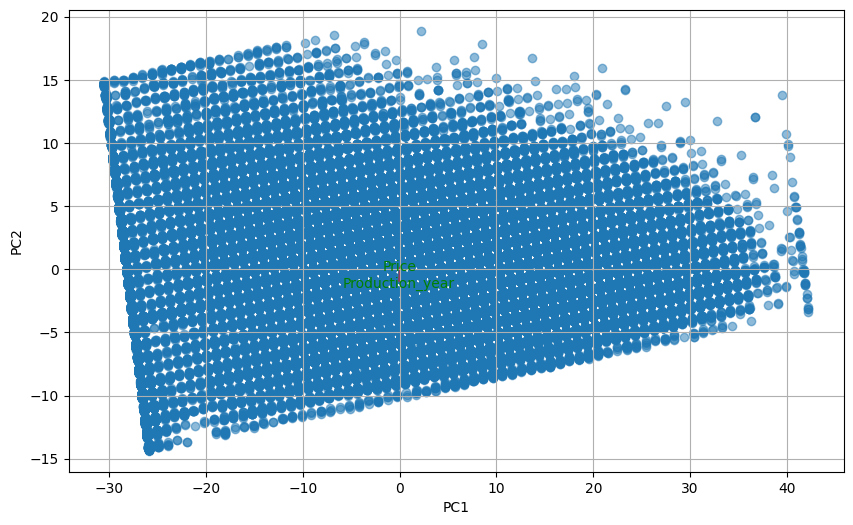

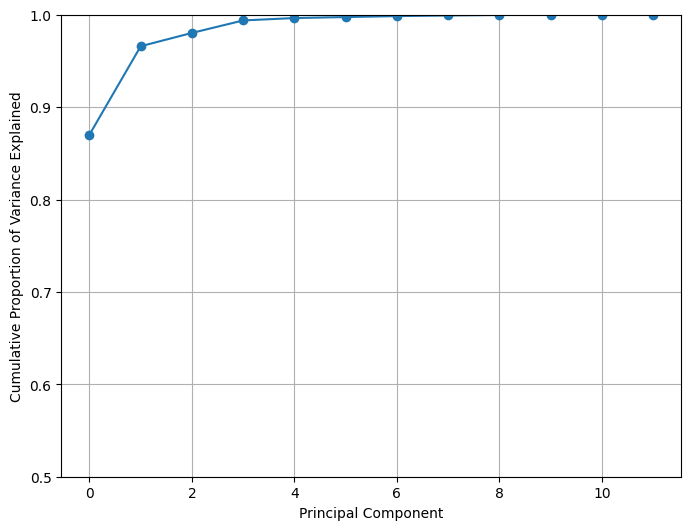

In [72]:
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

# Perform PCA with scaling
pca = PCA(n_components=len(df1_useful.columns))
pca.fit(df1_useful)

# Names of the principal components
print("Principal Component Names:")
print([f"PC{i+1}" for i in range(len(df1_useful.columns))])

# Rotation matrix
print("Rotation Matrix:")
print(pca.components_)

# Dimension of the transformed data
print("Dimensions of Transformed Data:")
print(pca.transform(df1_useful).shape)

# Biplot
def biplot(score, coeff, labels=None):
    plt.figure(figsize=(10, 6))
    plt.scatter(score[:,0], score[:,1], alpha=0.5)
    for i in range(coeff.shape[1]):
        plt.arrow(0, 0, coeff[0,i], coeff[1,i], color='r', alpha=0.5)
        if labels is None:
            plt.text(coeff[0,i]*1.15, coeff[1,i]*1.15, "Var"+str(i+1), color='g', ha='center', va='center')
        else:
            plt.text(coeff[0,i]*1.15, coeff[1,i]*1.15, labels[i], color='g', ha='center', va='center')
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.grid()

biplot(pca.transform(df1_useful)[:,0:2], np.transpose(pca.components_[0:2, :]), labels=df1_useful.columns)

# Standard deviations of the principal components
print("Standard Deviations of Principal Components:")
print(pca.explained_variance_)

# Variance explained
pve = pca.explained_variance_ratio_
print("Proportion of Variance Explained:")
print(pve)

# Cumulative proportion of variance explained
cumulative_pve = np.cumsum(pve)
print("Cumulative Proportion of Variance Explained:")
print(cumulative_pve)

# Plotting cumulative proportion of variance explained
plt.figure(figsize=(8, 6))
plt.plot(cumulative_pve, marker='o', linestyle='-')
plt.xlabel("Principal Component")
plt.ylabel("Cumulative Proportion of Variance Explained")
plt.ylim(0.5, 1)
plt.grid()
plt.show()


In [ ]:
# Variance explained for the first principal component
print("Variance Explained for the First Principal Component:")
print(pve[0])

# Variance explained for the first two principal components
print("Variance Explained for the First Two Principal Components:")
print(np.sum(pve[:2]))


Variance Explained for the First Principal Component:
0.8701817573240249
Variance Explained for the First Two Principal Components:
0.9659029618274921


In [ ]:
# Get the loadings of the original variables on the first two principal components
loadings_first_two_pc = pca.components_[:2]

# Get the absolute values of loadings
abs_loadings = np.abs(loadings_first_two_pc)

# Get the indices of variables with non-zero loadings
indices_with_loadings = np.where(abs_loadings > 0)

# Get the names of variables that exist in the first two principal components
variables_in_first_two_pc = df1_useful.columns[indices_with_loadings[1]]

# Get the names of variables that do not exist in the first two principal components
variables_not_in_first_two_pc = df1_useful.columns[~df1_useful.columns.isin(variables_in_first_two_pc)]

print("Variables in the first two principal components:")
print(variables_in_first_two_pc)
print("\nVariables not in the first two principal components:")
print(variables_not_in_first_two_pc)

Variables in the first two principal components:
Index(['Price', 'Production_year', 'Mileage_km', 'Power_HP',
       'Displacement_cm3', 'Fuel_type', 'Drive', 'Transmission', 'Type',
       'Doors_number', 'Colour', 'Extras', 'Price', 'Production_year',
       'Mileage_km', 'Power_HP', 'Displacement_cm3', 'Fuel_type', 'Drive',
       'Transmission', 'Type', 'Doors_number', 'Colour', 'Extras'],
      dtype='object')

Variables not in the first two principal components:
Index([], dtype='object')


K-Means Clustering

In [ ]:
print(df1_useful.isnull().sum())

Price               0
Production_year     0
Mileage_km          0
Power_HP            0
Displacement_cm3    0
Fuel_type           0
Drive               0
Transmission        0
Type                0
Doors_number        0
Colour              0
Extras              0
dtype: int64


In [ ]:
from sklearn.preprocessing import StandardScaler

# Initialize the StandardScaler
scaler = StandardScaler()

# Standardize the dataset
X = scaler.fit_transform(df1_useful)

# Create a DataFrame with standardized data
df1_multiple_scaled = pd.DataFrame(X, index=df1_useful.index, columns=df1_useful.columns)


In [ ]:
df1_multiple_scaled.head()

,Price,Production_year,Mileage_km,Power_HP,Displacement_cm3,Fuel_type,Drive,Transmission,Type,Doors_number,Colour,Extras
1,0.434465,-0.062894,-0.580677,-1.417178,-1.724656,1.017518,-0.127571,-0.679686,-0.513351,-3.266082,-0.093027,-1.921120
2,0.469527,1.257672,-0.690060,0.787036,-0.925937,1.017518,-0.127571,1.471268,0.016817,-2.015172,-0.093027,-0.539772
3,0.338851,0.125758,-1.195812,0.489608,-0.925937,1.017518,-0.127571,-0.679686,0.016817,-2.015172,0.451992,-0.401637
5,0.843494,0.880367,-0.795116,0.787036,-0.925937,1.017518,-0.127571,-0.679686,0.016817,-2.015172,0.451992,0.081835
6,0.959446,1.823629,-3.189844,0.241191,-0.925937,1.017518,-0.127571,-0.679686,0.016817,-3.266082,-0.638045,-1.921120


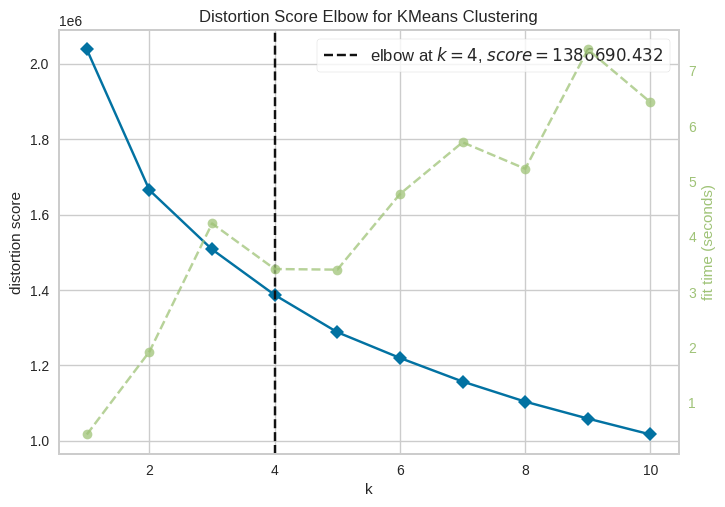

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [ ]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

kmeans = KMeans(random_state=0)
visualizer = KElbowVisualizer(kmeans, k=(1, 11))

visualizer.fit(df1_multiple_scaled)
visualizer.show()

In [ ]:
kmeans = KMeans(n_clusters=4, random_state=0)
kmeans.fit(df1_multiple_scaled)

KMeans(n_clusters=4, random_state=0)

In [ ]:
df1_multiple_scaled['cluster']=kmeans.labels_
df1_multiple_scaled.head()

,Price,Production_year,Mileage_km,Power_HP,Displacement_cm3,Fuel_type,Drive,Transmission,Type,Doors_number,Colour,Extras,cluster
1,0.434465,-0.062894,-0.580677,-1.417178,-1.724656,1.017518,-0.127571,-0.679686,-0.513351,-3.266082,-0.093027,-1.921120,2
2,0.469527,1.257672,-0.690060,0.787036,-0.925937,1.017518,-0.127571,1.471268,0.016817,-2.015172,-0.093027,-0.539772,0
3,0.338851,0.125758,-1.195812,0.489608,-0.925937,1.017518,-0.127571,-0.679686,0.016817,-2.015172,0.451992,-0.401637,0
5,0.843494,0.880367,-0.795116,0.787036,-0.925937,1.017518,-0.127571,-0.679686,0.016817,-2.015172,0.451992,0.081835,0
6,0.959446,1.823629,-3.189844,0.241191,-0.925937,1.017518,-0.127571,-0.679686,0.016817,-3.266082,-0.638045,-1.921120,0


In [ ]:
df1_multiple_scaled.columns

Index(['Price', 'Production_year', 'Mileage_km', 'Power_HP',
       'Displacement_cm3', 'Fuel_type', 'Drive', 'Transmission', 'Type',
       'Doors_number', 'Colour', 'Extras', 'cluster'],
      dtype='object')

In [ ]:
df1_multiple_scaled.info()

<class 'pandas.core.frame.DataFrame'>
Index: 169833 entries, 1 to 208303
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Price             169833 non-null  float64
 1   Production_year   169833 non-null  float64
 2   Mileage_km        169833 non-null  float64
 3   Power_HP          169833 non-null  float64
 4   Displacement_cm3  169833 non-null  float64
 5   Fuel_type         169833 non-null  float64
 6   Drive             169833 non-null  float64
 7   Transmission      169833 non-null  float64
 8   Type              169833 non-null  float64
 9   Doors_number      169833 non-null  float64
 10  Colour            169833 non-null  float64
 11  Extras            169833 non-null  float64
 12  cluster           169833 non-null  int32  
dtypes: float64(12), int32(1)
memory usage: 17.5 MB


In [ ]:
df1_multiple_scaled.shape

(169833, 13)

Exploring Clusters using visualizations

In [ ]:
# Convert 'cluster' to categorical for plotting
df1_multiple_scaled['cluster_cat'] = df1_multiple_scaled['cluster'].astype(str)

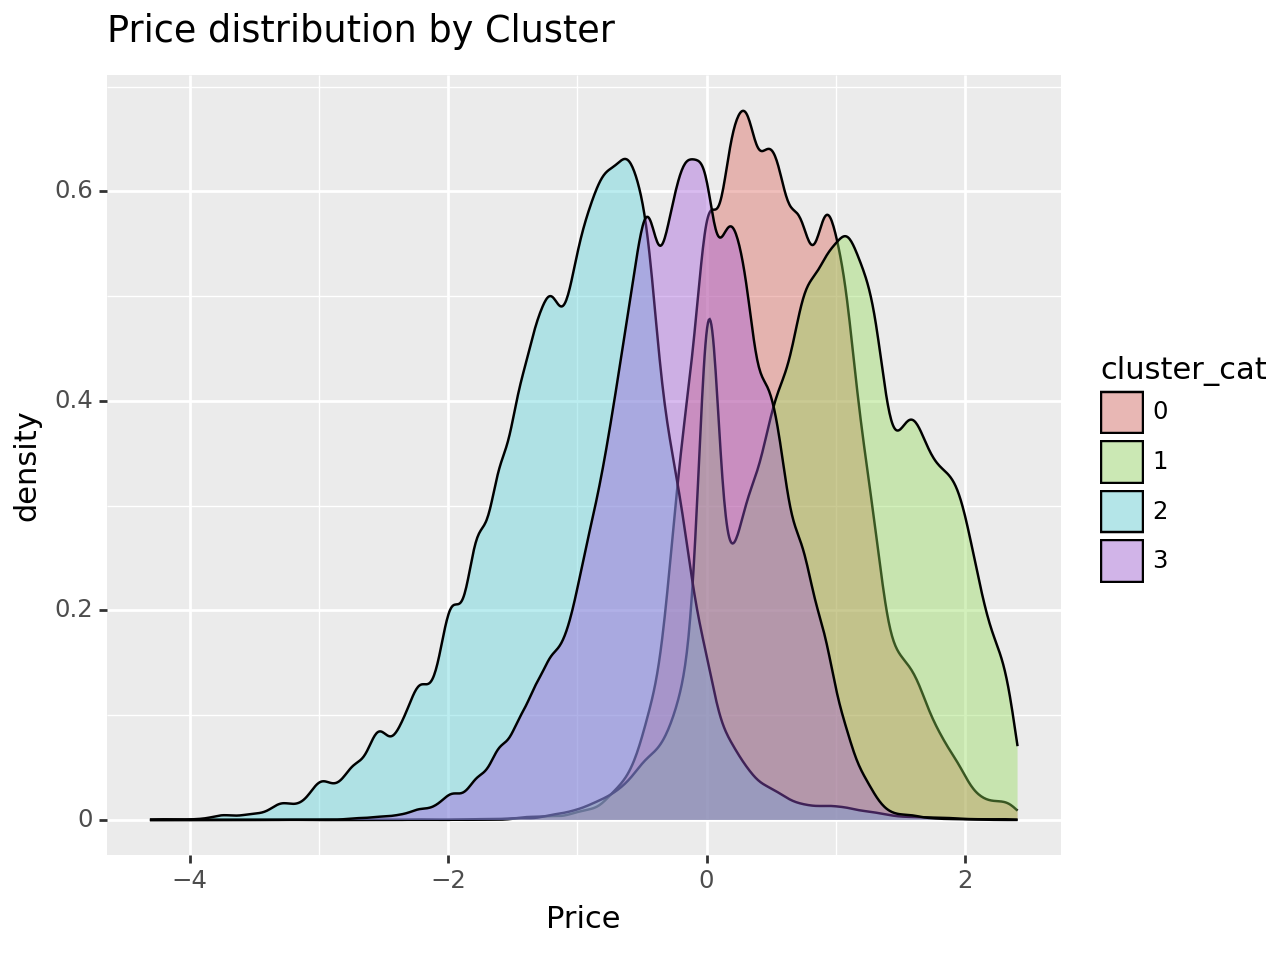

In [ ]:
from plotnine import ggplot, aes, geom_density, labs

p = ggplot(df1_multiple_scaled, aes(x='Price', fill='cluster_cat')) + \
    geom_density(alpha=0.4) + \
    labs(title="Price distribution by Cluster")

print(p)

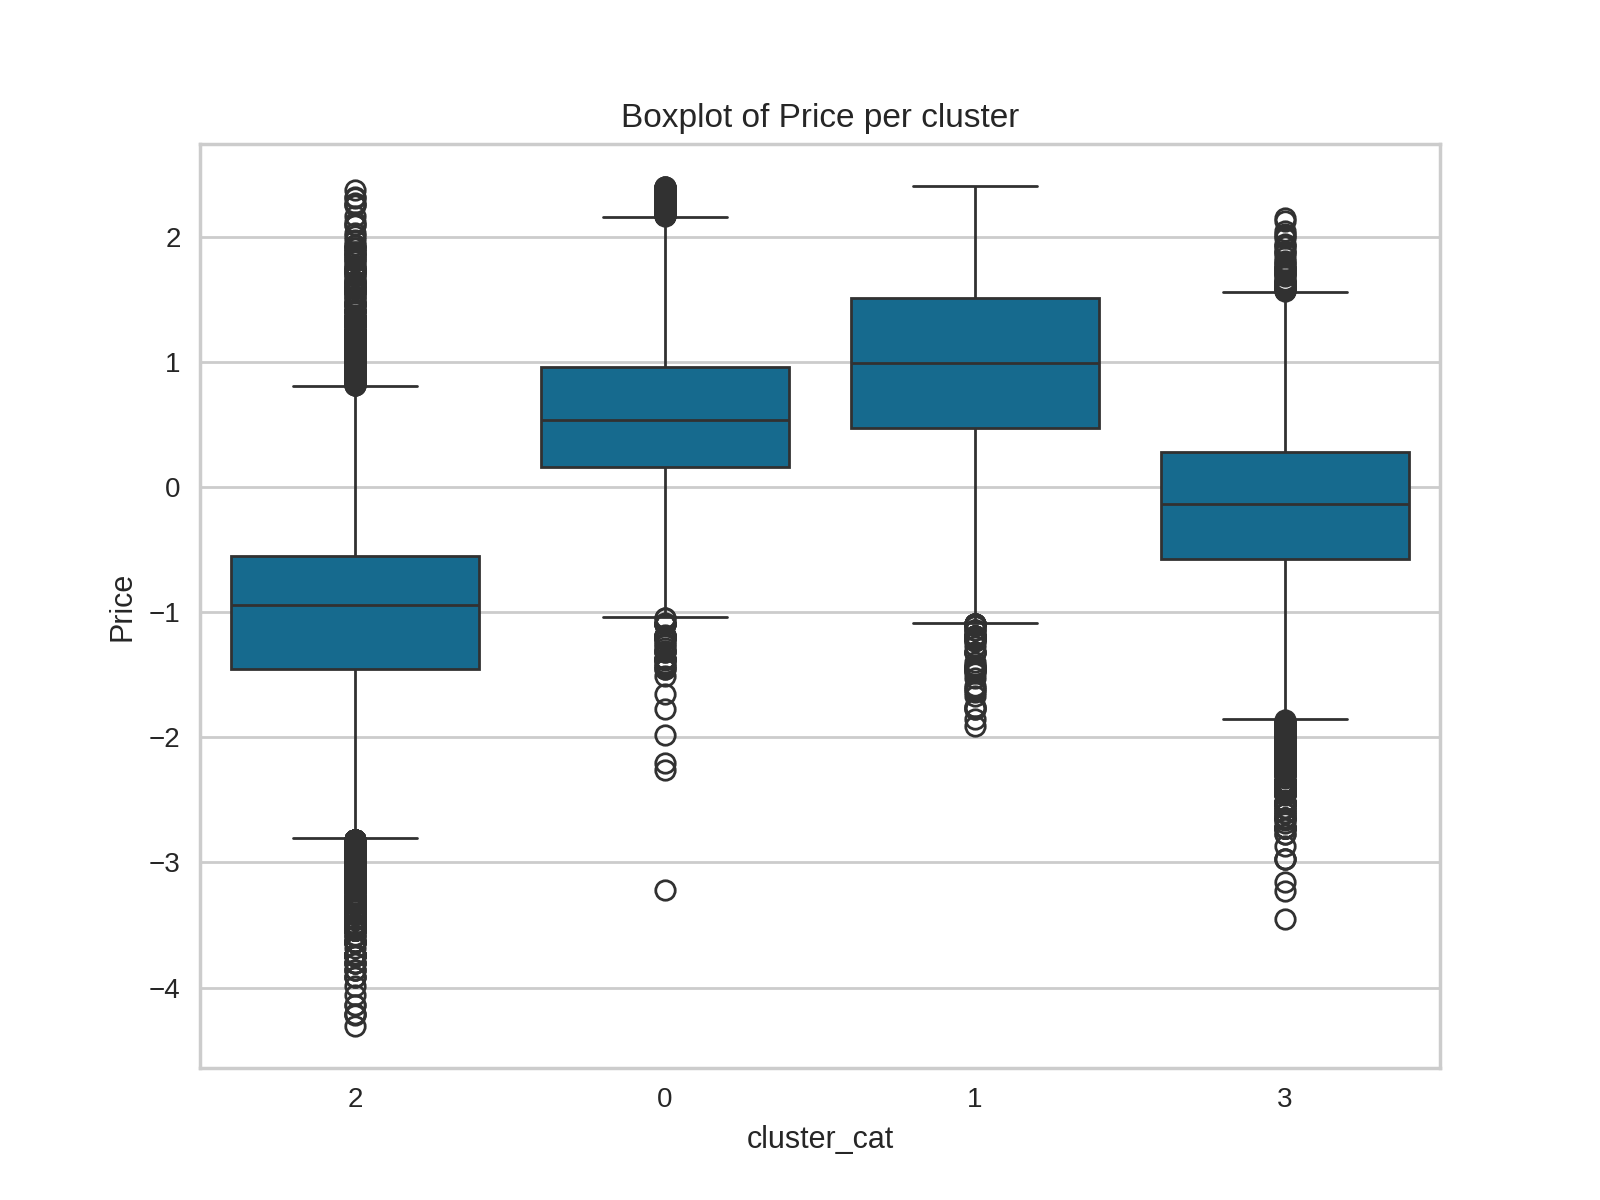

In [ ]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='cluster_cat', y='Price', data=df1_multiple_scaled)
plt.title('Boxplot of Price per cluster')
plt.show()

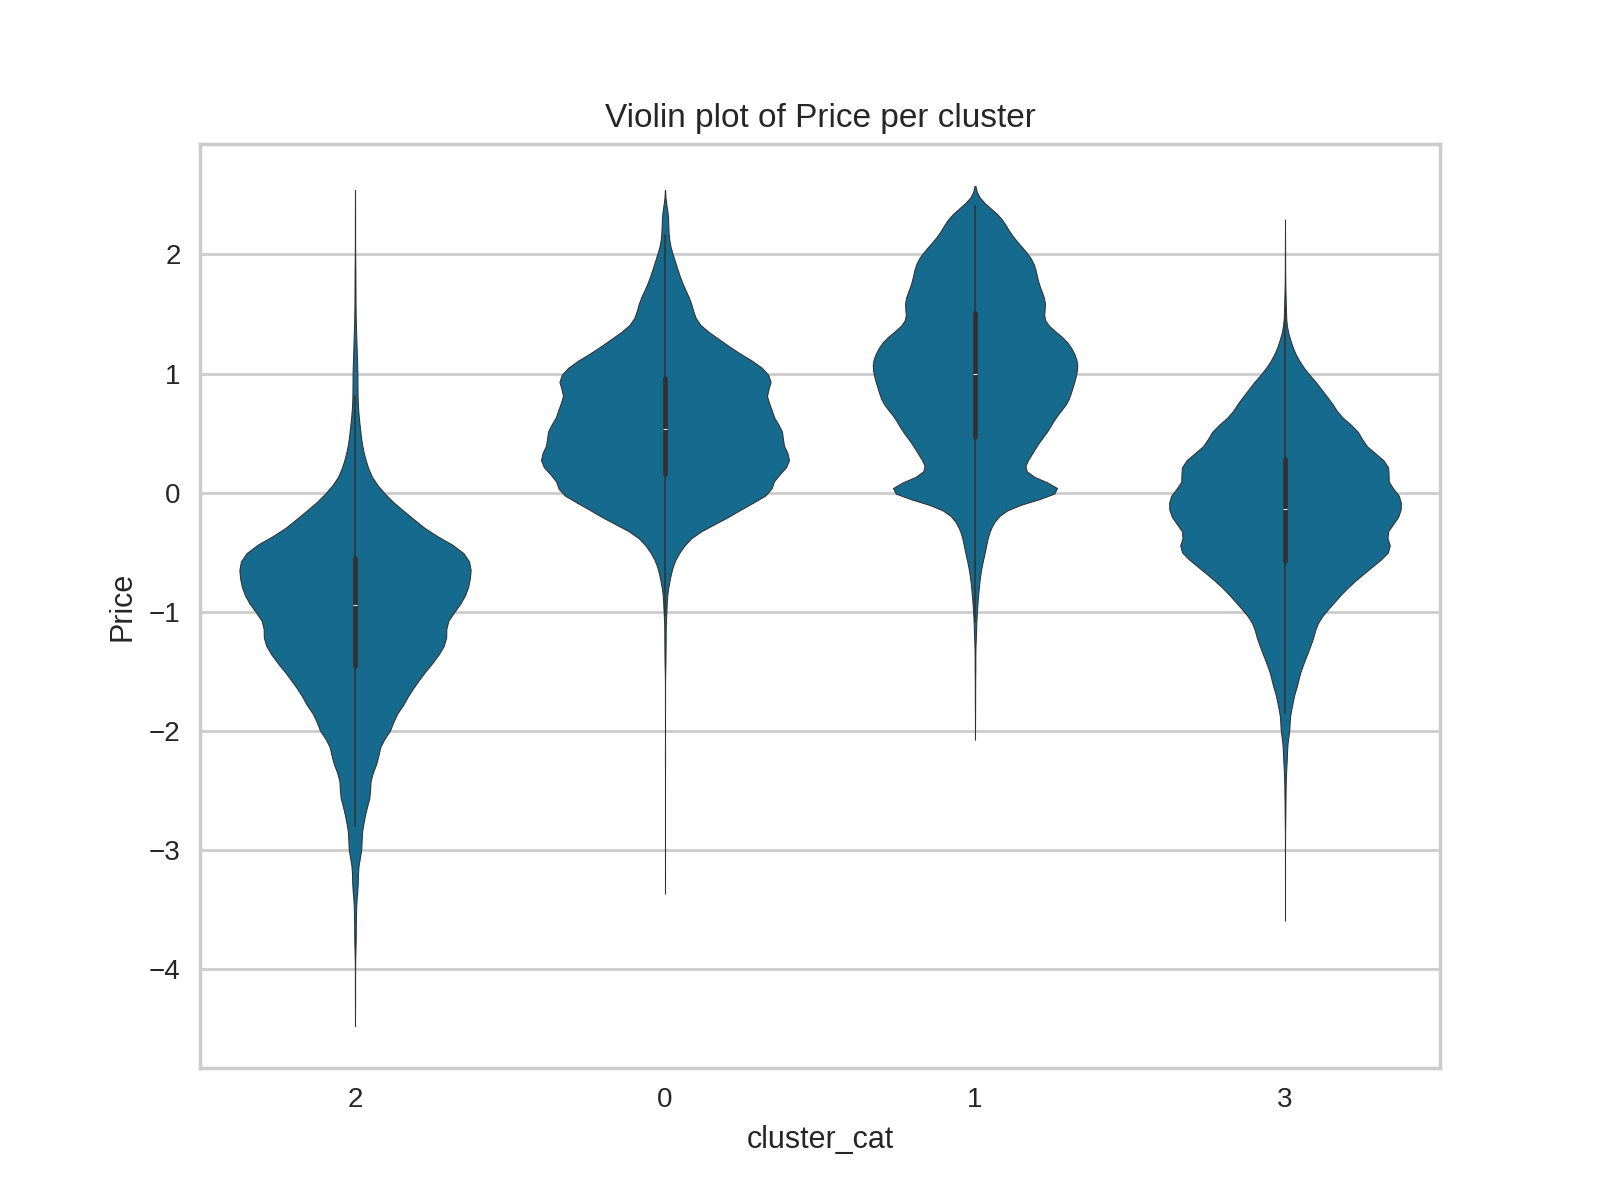

In [ ]:
plt.figure(figsize=(8, 6))
sns.violinplot(x='cluster_cat', y='Price', data=df1_multiple_scaled)
plt.title('Violin plot of Price per cluster')
plt.show()

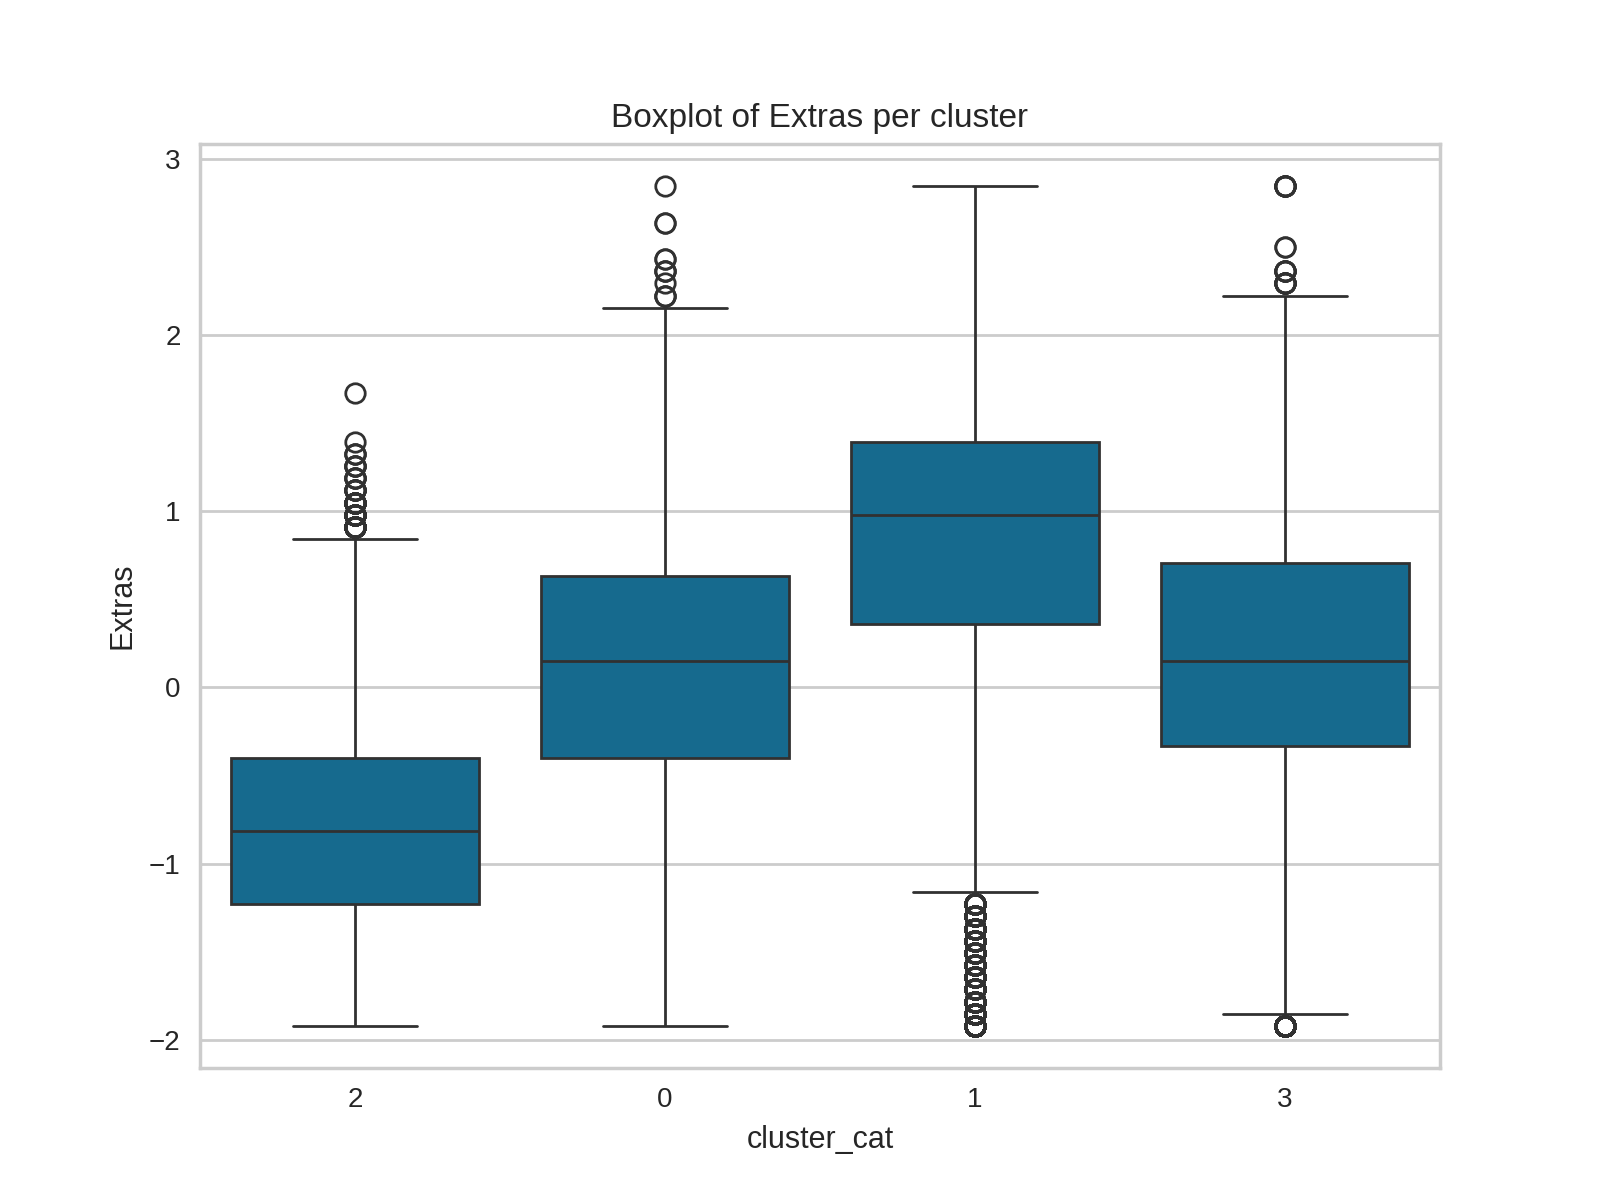

In [ ]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='cluster_cat', y='Extras', data=df1_multiple_scaled)
plt.title('Boxplot of Extras per cluster')
plt.show()

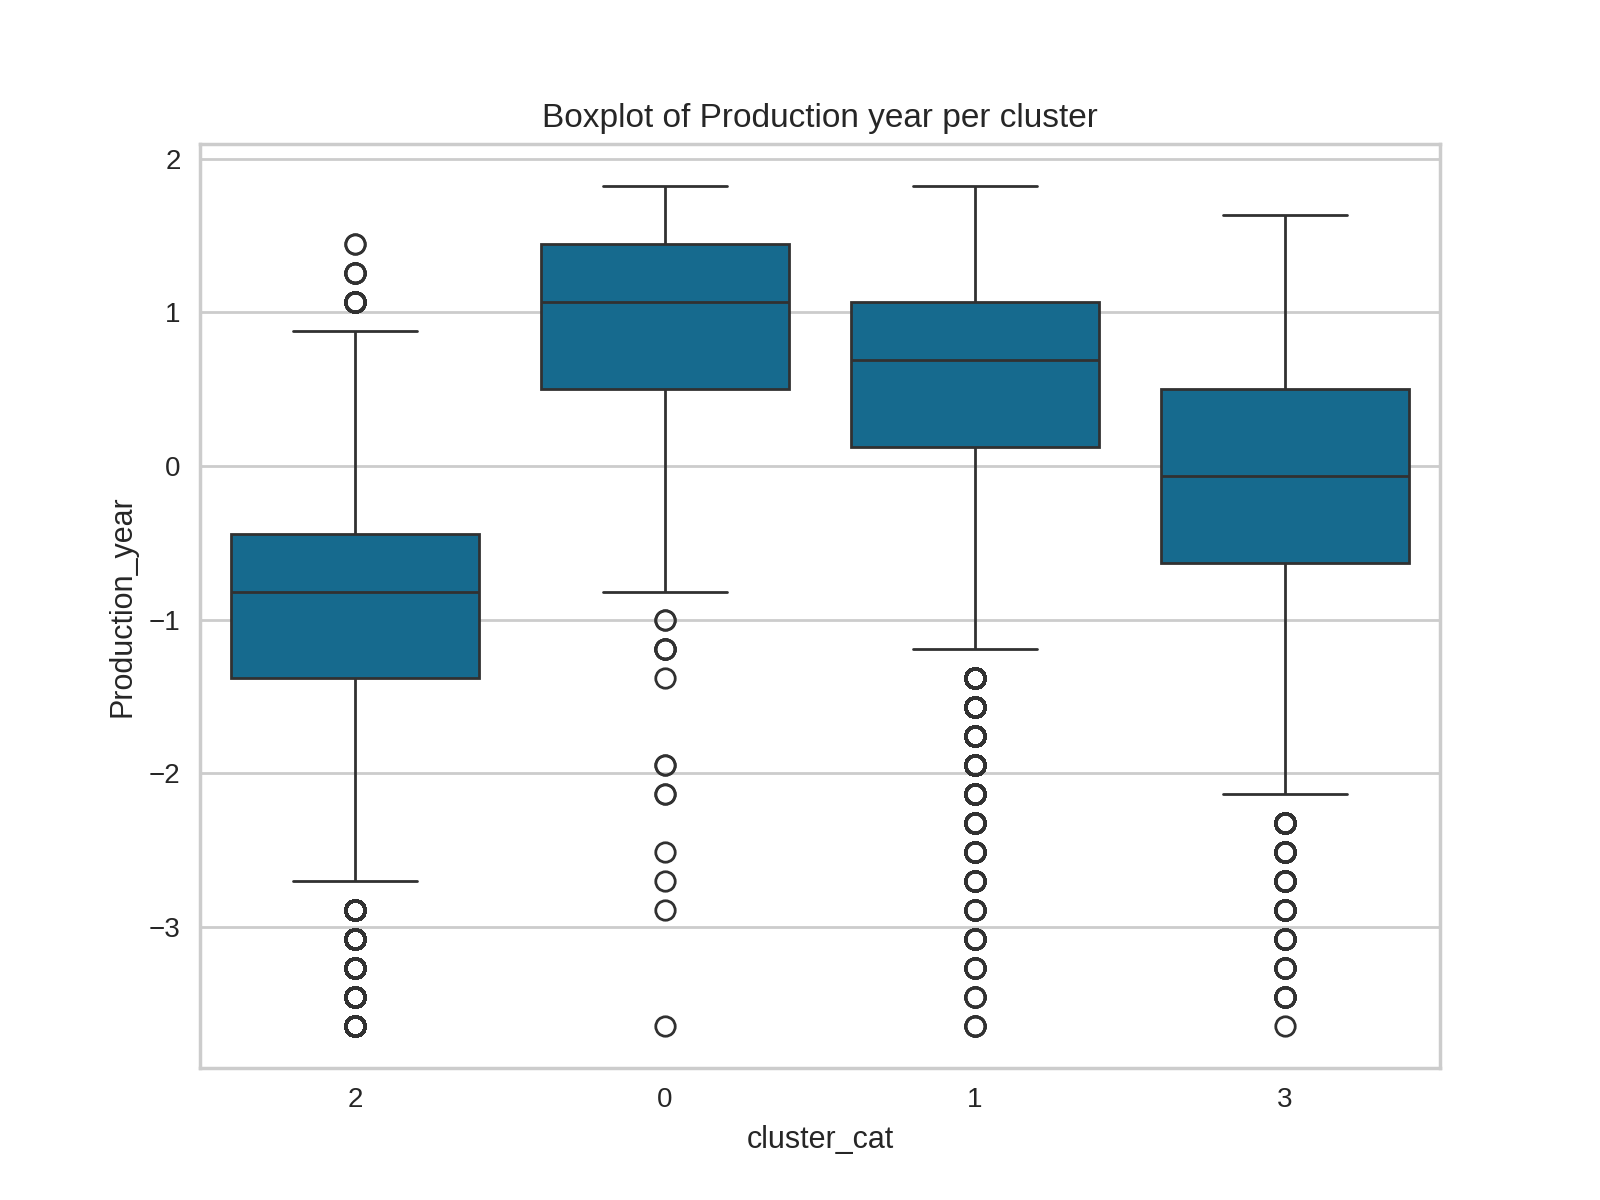

In [ ]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='cluster_cat', y='Production_year', data=df1_multiple_scaled)
plt.title('Boxplot of Production year per cluster')
plt.show()

In [ ]:
print(df1_multiple_scaled['cluster_cat'].unique())
unique_cluster_cat_counts = df1_multiple_scaled['cluster_cat'].value_counts()
print(unique_cluster_cat_counts)

['2' '0' '1' '3']
cluster_cat
3    59415
2    43080
1    39706
0    27632
Name: count, dtype: int64


In [ ]:
# Remove the temporary categorical column cluster_cat
df1_multiple_scaled.drop(columns=['cluster_cat'], inplace=True)

I am  creating an SVM model that can classify each new entry at one of the four  pre-specified clusters

SVM Model

In [ ]:
!pip install joblib

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
import joblib
from google.colab import files


# Taking a random sample of 100,000 rows
sample_size = 100000
random_state = 123

subset_df = df1_multiple_scaled.sample(n=sample_size, random_state=random_state)

# Drop the 'Price' column from the dataset
subset_df = subset_df.drop('Price', axis=1)

# Splitting the dataset into features (X) and target (y)
X = subset_df.drop('cluster', axis=1)
y = subset_df['cluster']

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

# Standardizing the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Setting up parameter grid for grid search
param_grid = {
    'C': [0.01, 1, 10],
    'gamma': [0.5, 1, 2],
    'kernel': ['rbf']
}

# Initializing SVM classifier with probability=True
svm = SVC(probability=True)

# Grid search for tuning hyperparameters
grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train_scaled, y_train)

# Best parameters
print("Best parameters found: ", grid_search.best_params_)

# Predictions on test set
y_pred = grid_search.predict(X_test_scaled)

# Accuracy score
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Obtain probabilities for each class on the test set
y_probs = grid_search.predict_proba(X_test_scaled)

# Initialize SVM classifier with best parameters
best_svm = SVC(C=grid_search.best_params_['C'], gamma=grid_search.best_params_['gamma'], kernel='rbf', probability=True)

# Train the final SVM model on the entire training dataset
best_svm.fit(X_train_scaled, y_train)

# Save the trained SVM model
joblib.dump(best_svm, 'svm_model_final_trained.pkl')

# Download the trained SVM model file
files.download('svm_model_final_trained.pkl')


Fitting 3 folds for each of 9 candidates, totalling 27 fits
Best parameters found:  {'C': 1, 'gamma': 0.5, 'kernel': 'rbf'}
Accuracy: 0.9612


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!pip install scikit-plot

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import StandardScaler
import joblib

# Taking a random sample of 40,000 rows
subset_df = df1_multiple_scaled.sample(n=40000, random_state=123)

# Drop the 'Price' column from the dataset
subset_df = subset_df.drop('Price', axis=1)

# Splitting the dataset into features (X) and target (y)
X = subset_df.drop('cluster', axis=1)
y = subset_df['cluster']

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# Standardizing the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

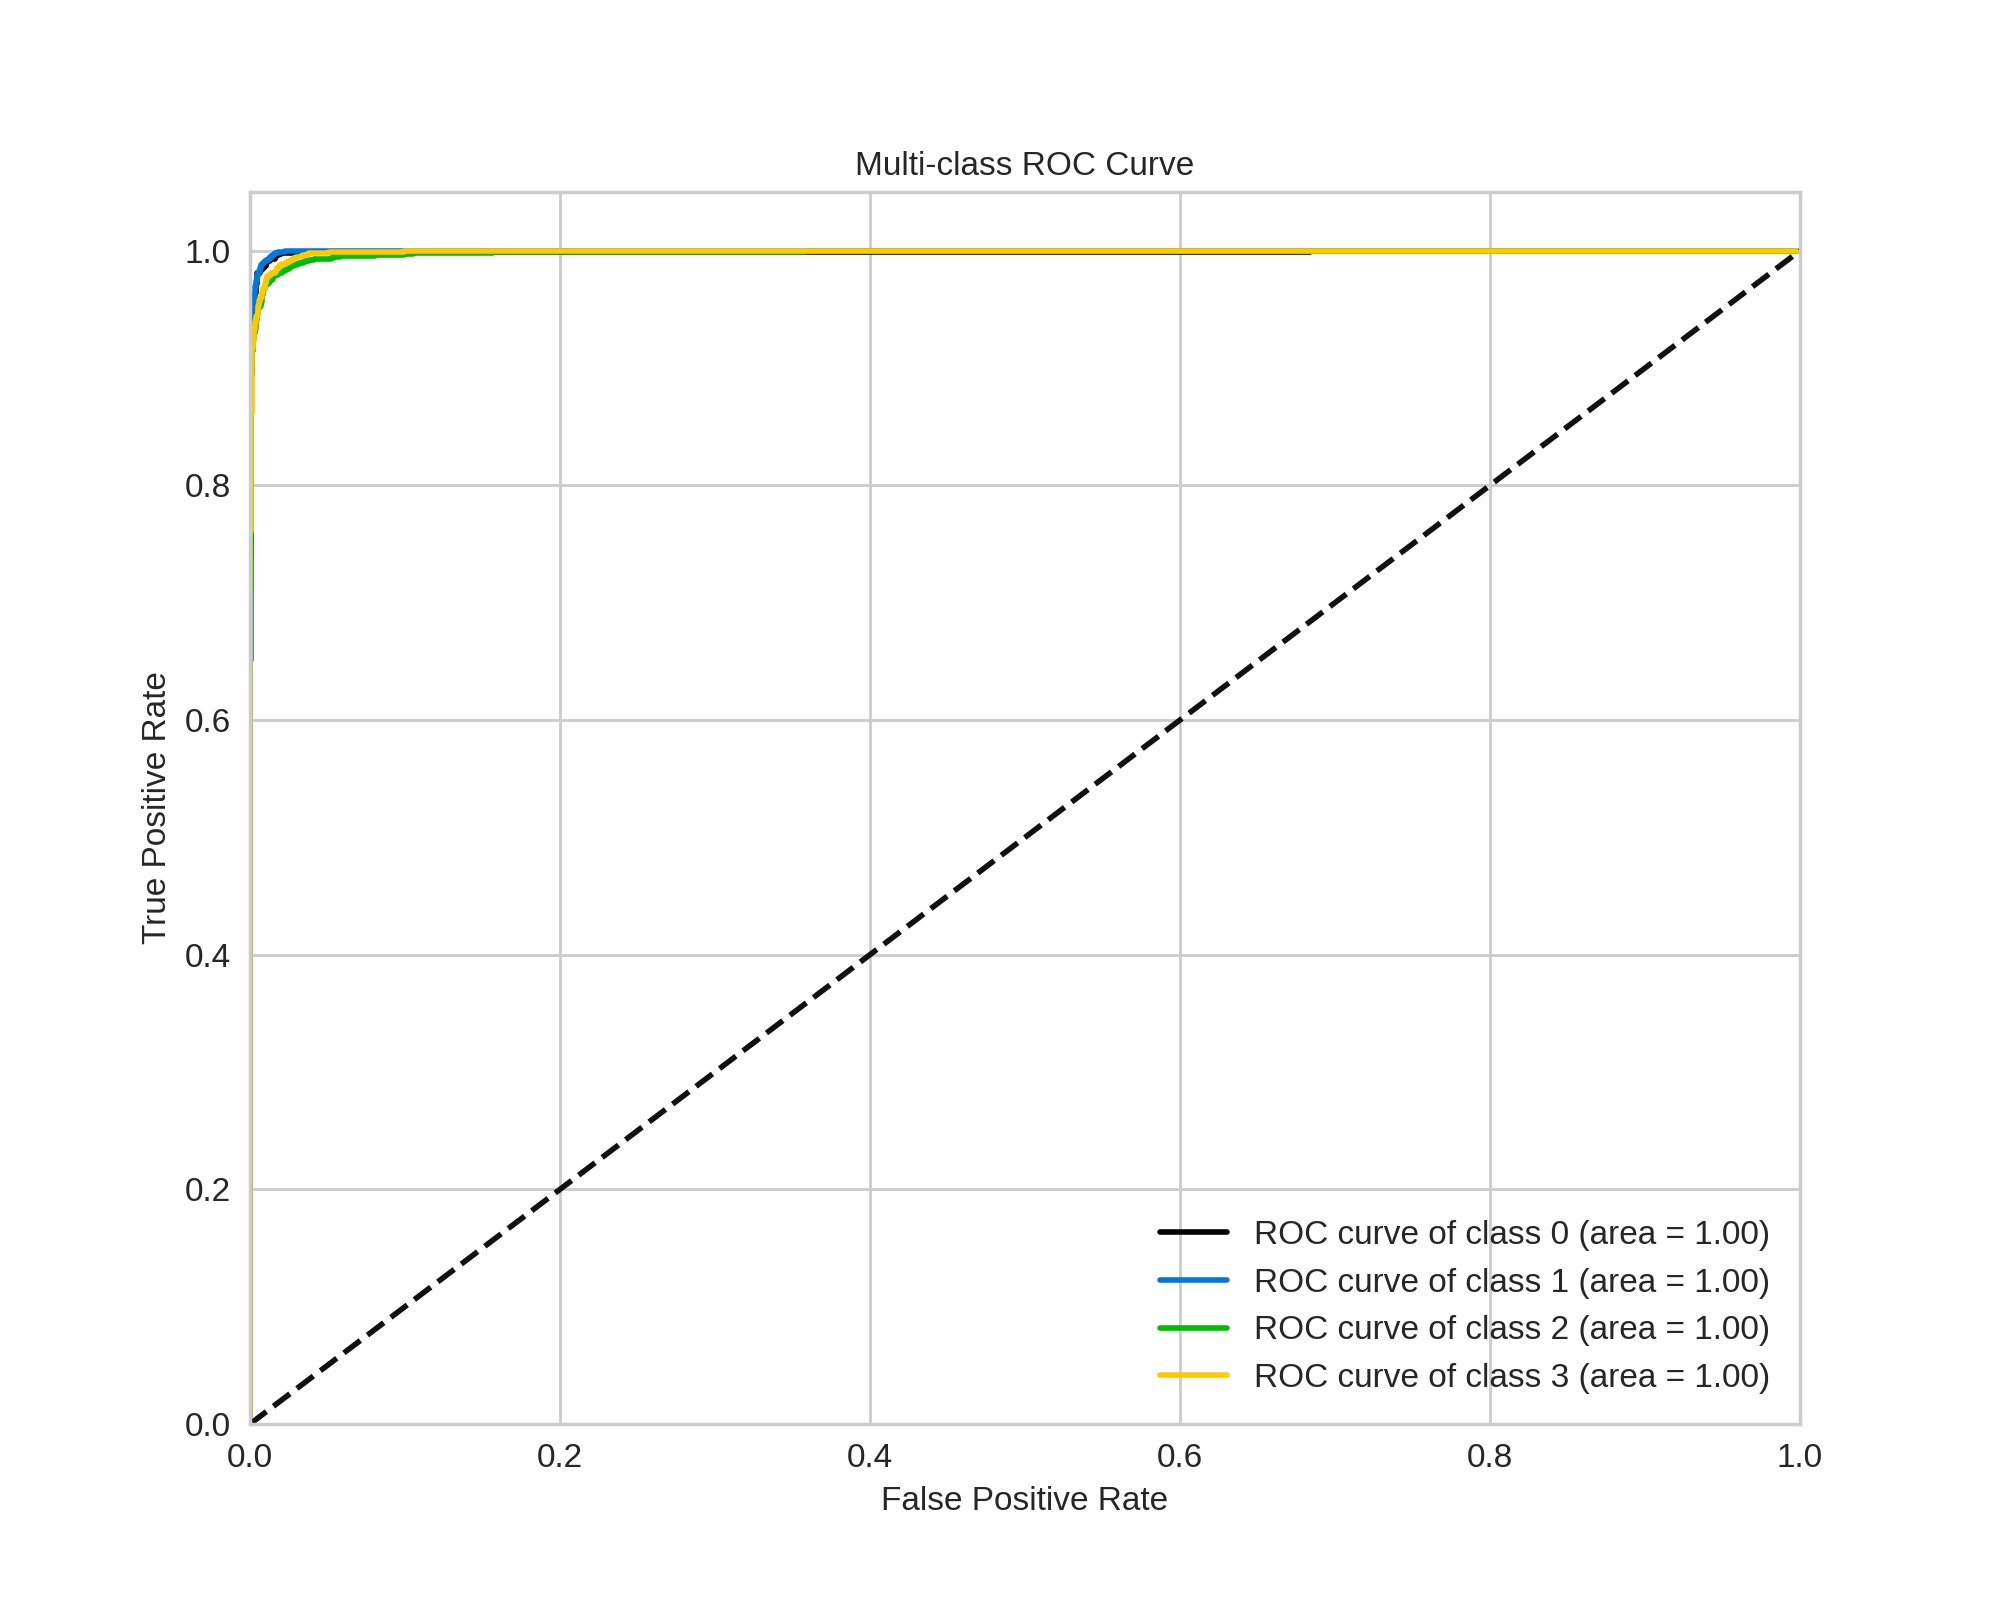

Multi-class AUC Score: 0.9988243503660952


In [ ]:
import joblib
import scikitplot as skplt
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

# Load the trained SVM model
best_svm = joblib.load('/content/svm_model_final_trained.pkl')

# Predict probabilities for each class on the test set
y_probs = best_svm.predict_proba(X_test_scaled)

# Calculate and plot multi-class ROC curve
skplt.metrics.plot_roc(y_test, y_probs, figsize=(10, 8), plot_micro=False, plot_macro=False, classes_to_plot=[0, 1, 2, 3, 4, 5, 6, 7, 8])
plt.title('Multi-class ROC Curve')
plt.show()

# Calculate and print multi-class AUC score
auc_score = roc_auc_score(y_test, y_probs, multi_class='ovo', average='macro')
print("Multi-class AUC Score:", auc_score)


In [ ]:
# Calculate and print total (weighted) AUC score
weighted_auc_score = roc_auc_score(y_test, y_probs, multi_class='ovo', average='weighted')
print("Total AUC Score:", weighted_auc_score)


Total AUC Score: 0.9988238018056683


In [ ]:
from sklearn.metrics import accuracy_score

# Predictions on test set
y_pred = best_svm.predict(X_test_scaled)

# Calculate accuracy score
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.97625


I am creating a random forest model that can predict the price of a new entry based on the attributes of the car

Random Forest Model for the full dataset

In [ ]:
# Sample 10% of the dataset
sample_df = df1_multiple_scaled.sample(frac=0.1, random_state=123)


In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.metrics import mean_squared_error
import joblib
from google.colab import files

# Sample 10% of the dataset
sample_df = df1_multiple_scaled.sample(frac=0.1, random_state=123)

# Prepare the features (X) and target variable (y) for the sample dataset
X = sample_df.drop(['Price'], axis=1)
y = sample_df['Price']

# Split the sample dataset into training and testing sets
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=2)

# Step 1: Cross-Validation for Model Selection
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees
    'max_depth': [None, 10, 20],  # Maximum depth of trees
}

# Initialize Random Forest Regressor
rf = RandomForestRegressor(random_state=123)

# Grid Search with Cross-Validation
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=2)
grid_search.fit(train_X, train_y)

# Best parameters from Grid Search
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Step 2: Cross-Validation with Best Model
kf = KFold(n_splits=5, shuffle=True, random_state=123)
mse_scores = []

for train_index, val_index in kf.split(train_X):
    X_train, X_val = train_X.iloc[train_index], train_X.iloc[val_index]
    y_train, y_val = train_y.iloc[train_index], train_y.iloc[val_index]

    best_model.fit(X_train, y_train)
    y_pred = best_model.predict(X_val)
    mse = mean_squared_error(y_val, y_pred)
    mse_scores.append(mse)

# Average Mean Squared Error
average_mse = np.mean(mse_scores)
print(f"Average MSE on Cross-Validation: {average_mse}")

# Step 3: Evaluate Performance on Test Set
test_pred = best_model.predict(test_X)
test_mse = mean_squared_error(test_y, test_pred)
print(f"Test MSE: {test_mse}")

# Save the final model to disk
filename = 'sample_random_forest_model.sav'
joblib.dump(best_model, filename)

# Download the trained random forest model file
files.download(filename)


Fitting 5 folds for each of 9 candidates, totalling 45 fits
Average MSE on Cross-Validation: 0.14224403602871574
Test MSE: 0.14757194552745828


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [75]:
from google.colab import files

In [76]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.metrics import mean_squared_error
import joblib

# Prepare the features (X) and target variable (y) for the full dataset
X = df1_useful.drop(['Price'], axis=1)
y = df1_useful['Price']

# Split the full dataset into training and testing sets
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=2)

# Step 1: Cross-Validation for Model Selection
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees
    'max_depth': [None, 10, 20],  # Maximum depth of trees
}

# Initialize Random Forest Regressor
rf = RandomForestRegressor(random_state=123)

# Grid Search with Cross-Validation
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=2)
grid_search.fit(train_X, train_y)

# Best parameters from Grid Search
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Step 2: Cross-Validation with Best Model
kf = KFold(n_splits=5, shuffle=True, random_state=123)
mse_scores = []

for train_index, val_index in kf.split(train_X):
    X_train, X_val = train_X.iloc[train_index], train_X.iloc[val_index]
    y_train, y_val = train_y.iloc[train_index], train_y.iloc[val_index]

    best_model.fit(X_train, y_train)
    y_pred = best_model.predict(X_val)
    mse = mean_squared_error(y_val, y_pred)
    mse_scores.append(mse)

# Average Mean Squared Error
average_mse = np.mean(mse_scores)
print(f"Average MSE on Cross-Validation: {average_mse}")

# Step 3: Evaluate Performance on Test Set
test_pred = best_model.predict(test_X)
test_mse = mean_squared_error(test_y, test_pred)
print(f"Test MSE: {test_mse}")

# Save the final model to disk
filename = 'full_random_forest_model.sav'
joblib.dump(best_model, filename)

# Download the trained random forest model file
files.download(filename)


Fitting 5 folds for each of 9 candidates, totalling 45 fits
Average MSE on Cross-Validation: 0.018503047408016924
Test MSE: 0.018539077140778223


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [77]:
import joblib

full_random_forest_model = joblib.load('/content/full_random_forest_model.sav')

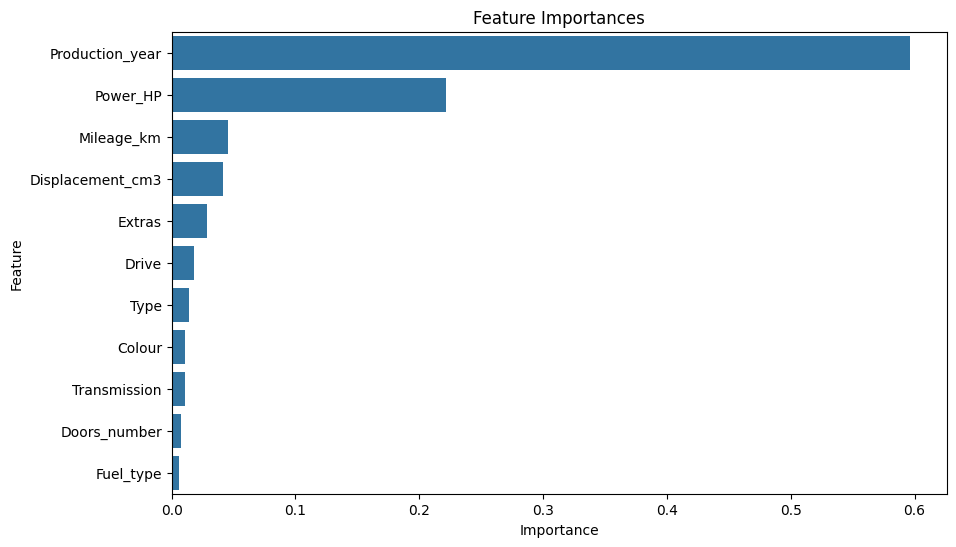

In [78]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get feature importances from the trained model
importances = best_model.feature_importances_

# Create a DataFrame for visualization
feature_names = train_X.columns
feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort the DataFrame by importance
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances)
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


In [86]:


# Sample 20000 rows from df1_useful
sample = df1_useful.sample(n=20000, random_state=42)

# Separate the target variable from the features
sample_without_price = sample.drop(columns=['Price'])

# Load the trained model
filename = 'full_random_forest_model.sav'
full_random_forest_model = joblib.load(filename)

# Predict price using the loaded model
price_prediction = full_random_forest_model.predict(sample_without_price)

# Add predictions to the DataFrame
sample['price_prediction'] = price_prediction

# Display the first few rows of the sample DataFrame with predictions
print(sample.head())


           Price  Production_year  Mileage_km  Power_HP  Displacement_cm3  \
36402   4.109916             2005    5.319941  2.136721          3.272074   
183472  3.740126             2008    5.223794  2.113943          3.254064   
126106  3.928754             2014    5.238049  2.214844          3.291591   
194473  4.258805             2017    5.100374  2.178977          3.294246   
130250  3.132580             2006    5.544069  2.082785          3.281261   

        Fuel_type  Drive  Transmission  Type  Doors_number  Colour  Extras  \
36402           1     -1             0     0           2.0      -1      34   
183472          1      0             0     2           5.0       1      31   
126106          0      0             0     3           5.0      -1      43   
194473          0      0             1     2           5.0       1      33   
130250          0      0             0     3           5.0       3      33   

        price_prediction  
36402           4.089606  
183472        

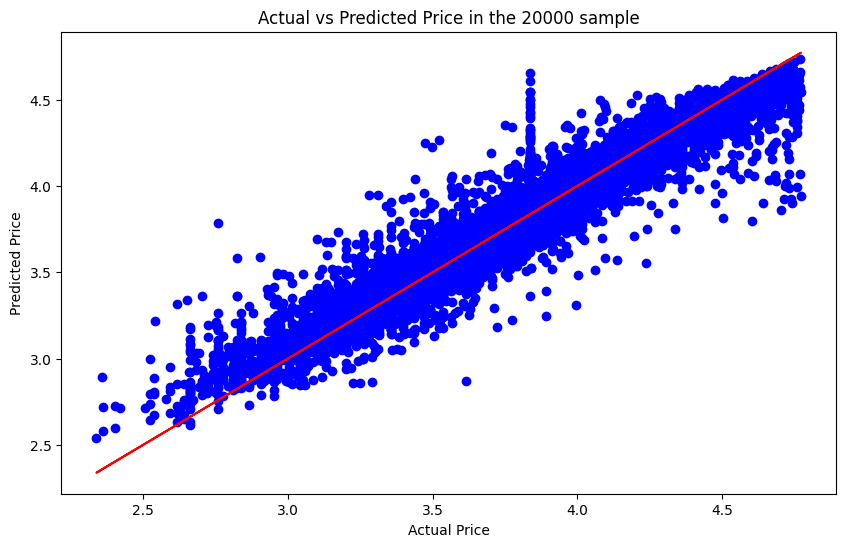

In [87]:
# Extract 'Price' and 'price_prediction' columns from sample
actual_price = sample['Price']
predicted_price = sample['price_prediction']

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(actual_price, predicted_price, color='blue')
plt.plot(actual_price, actual_price, color='red')  # Add a diagonal line for reference
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted Price in the 20000 sample')
plt.show()

In [88]:
# Calculate percentage error
sample['Price_percentage_error'] = (((sample['Price'] - sample['price_prediction']) / sample['Price']))*100


In [89]:
# Compute basic statistics of Price_percentage_error
price_percentage_error_stats = sample['Price_percentage_error'].describe()

# Print the statistics
print(price_percentage_error_stats)

count    20000.000000
mean        -0.042186
std          2.627946
min        -37.134905
25%         -0.867050
50%          0.143194
75%          1.091329
max         20.720672
Name: Price_percentage_error, dtype: float64
